In [1]:
import pickle
import numpy as np
from topicmodelling import TopicModelling
from hyperopt import hp
import pandas as pd

2024-04-07 14:40:47.047810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 14:40:50.418465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
product_asin='B018Y229OU'

with open(f'Reviews_{product_asin}.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
import os
os.environ['XDG_CACHE_HOME'] = '/w/284/mahamm/.cache'
os.environ['HF_HOME'] = '/w/284/mahamm/.cache'

In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
# load intents dataset
all_intents = list(data.review)

# define the document embedding models to use for comparison
model_st1 = SentenceTransformer('thenlper/gte-large') #all-mpnet-base-v2
#model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
#model_st3 = SentenceTransformer('paraphrase-mpnet-base-v2')

# generate embeddings for each model
embeddings_st1 = model_st1.encode(all_intents)
#embeddings_st2 = model_st2.encode(all_intents)
#embeddings_st3 = model_st3.encode(all_intents)

In [6]:
data['embeddings_st1']=embeddings_st1.tolist()
#data['embeddings_st2']=embeddings_st2.tolist()
#data['embeddings_st3']=embeddings_st3.tolist()
data

,product,year,review,predef_sentiment,zc_sentiment,embeddings_st1
0,B018Y229OU,2016,"Good basic tablet for checking email , web bro...",positive,positive,"[-0.029771825298666954, -0.03292471915483475, ..."
1,B018Y229OU,2016,I love this tablet.,positive,positive,"[-0.02808842994272709, -0.03607497364282608, -..."
2,B018Y229OU,2016,It was a great buy.,positive,positive,"[0.0070809535682201385, -0.02170313335955143, ..."
3,B018Y229OU,2016,I would strongly recommend buying it.,positive,positive,"[-0.008456842042505741, -0.01285533793270588, ..."
4,B018Y229OU,2016,It's a great reader but also good for surfing ...,positive,positive,"[-0.029224948957562447, -0.03411388769745827, ..."
...,...,...,...,...,...,...
27594,B018Y229OU,2017,excellent for learning and u don't use data.,neutral,positive,"[-0.006072483025491238, 0.004132324364036322, ..."
27595,B018Y229OU,2017,Bought this for my four year old niece and she...,positive,positive,"[-0.027378825470805168, 0.0003397386462893337,..."
27596,B018Y229OU,2017,Its exactly what I am wanted and the price was...,positive,positive,"[-0.041861310601234436, -0.009184174239635468,..."
27597,B018Y229OU,2017,Awesome tablet it's fast and easy to use.,positive,positive,"[-0.016371315345168114, -0.009903023950755596,..."


In [7]:
negative_reviews_predef = data[data.predef_sentiment=='negative']
negative_reviews_zc = data[data.zc_sentiment=='negative']
positive_reviews_predef = data[data.predef_sentiment=='positive']
positive_reviews_zc = data[data.zc_sentiment=='positive']
neutral_reviews_predef = data[data.predef_sentiment=='neutral']
neutral_reviews_zc = data[data.zc_sentiment=='neutral']

**PREDEFINED MODEL SENTIMENTS**

***NEGATIVE***

In [8]:
embeddings_st1.shape

(27599, 1024)

In [9]:
np.array([np.array(embedding) for embedding in negative_reviews_predef.embeddings_st1],dtype=np.float32).shape

(2484, 1024)

In [10]:
predef_neg_model_st1 = TopicModelling(np.array([np.array(embedding) for embedding in negative_reviews_predef.embeddings_st1],dtype=np.float32), 'st1')
#predef_neg_model_st2 = TopicModelling(np.array([np.array(embedding) for embedding in negative_reviews_predef.embeddings_st2],dtype=np.float32), 'st2')
#predef_neg_model_st3 = TopicModelling(np.array([np.array(embedding) for embedding in negative_reviews_predef.embeddings_st3],dtype=np.float32), 'st3')

In [11]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,15)),
    "min_samples": None,
    "random_state": 42
}

label_lower = 5
label_upper = 30
max_evals = 100

In [12]:
predef_neg_model_st1.bayesian_search(space=hspace,
                        label_lower=label_lower, 
                        label_upper=label_upper, 
                        max_evals=max_evals)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/w/340/mahamm/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)



100%|██████████| 100/100 [20:22<00:00, 12.22s/trial, best loss: 0.15]            
best:
{'min_cluster_size': 13, 'min_samples': None, 'n_components': 11, 'n_neighbors': 8, 'random_state': 42}
label count: 2


({'min_cluster_size': 13,
  'min_samples': None,
  'n_components': 11,
  'n_neighbors': 8,
  'random_state': 42},
 HDBSCAN(gen_min_span_tree=True, min_cluster_size=13),
 <hyperopt.base.Trials at 0x7fa88286ae00>)

39
0.3115942028985507


/w/340/mahamm/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


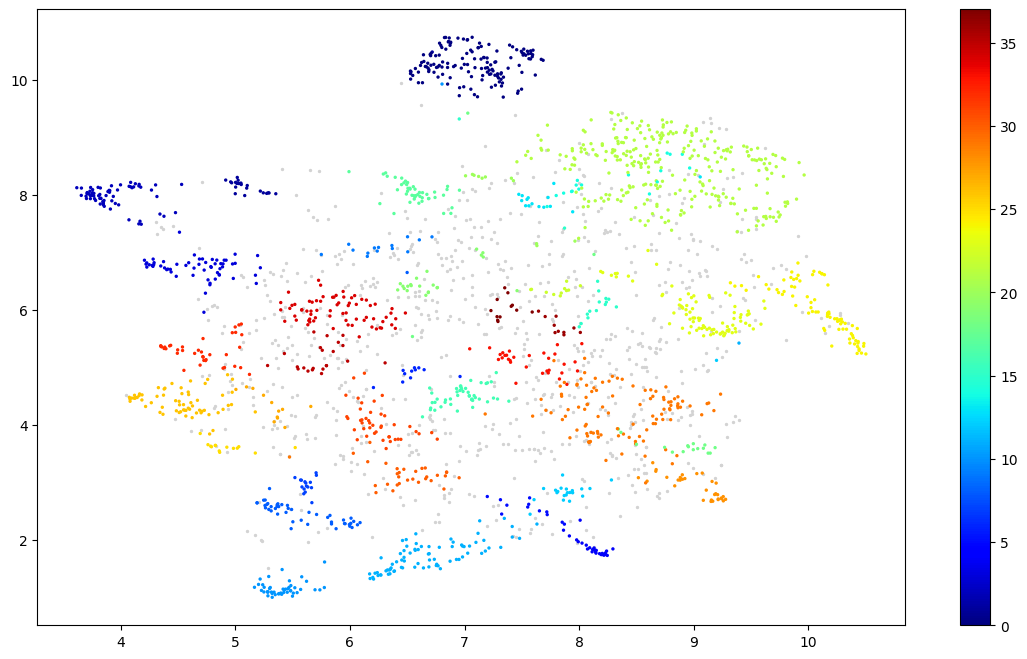

In [14]:
neg_best_clusters = predef_neg_model_st1.generate_clusters(n_neighbors = 10, 
                                              n_components = 6, 
                                              min_cluster_size = 10, 
                                              min_samples = None,
                                              random_state=42)
labels_manual, cost_manual = predef_neg_model_st1.score_clusters(neg_best_clusters)
print(labels_manual)
print(cost_manual)
predef_neg_model_st1.best_clusters = neg_best_clusters
predef_neg_model_st1.plot_best_clusters()

36
0.37393640841916703


/w/340/mahamm/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


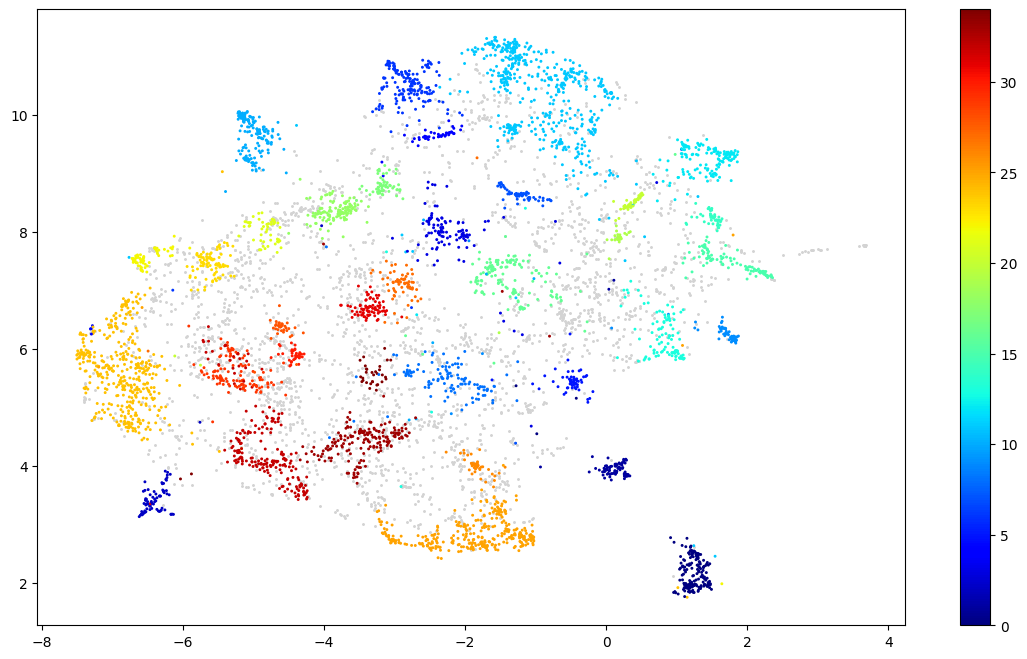

In [10]:
predef_neutral_model_st1 = TopicModelling(np.array([np.array(embedding) for embedding in neutral_reviews_predef.embeddings_st1],dtype=np.float32), 'st1')
neutral_best_clusters = predef_neutral_model_st1.generate_clusters(n_neighbors = 10, 
                                              n_components = 6, 
                                              min_cluster_size = 30, 
                                              min_samples = None,
                                              random_state=42)
labels_manual, cost_manual = predef_neutral_model_st1.score_clusters(neutral_best_clusters)
print(labels_manual)
print(cost_manual)
predef_neutral_model_st1.best_clusters = neutral_best_clusters
predef_neutral_model_st1.plot_best_clusters()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

68
0.21866854908774977


/w/340/mahamm/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


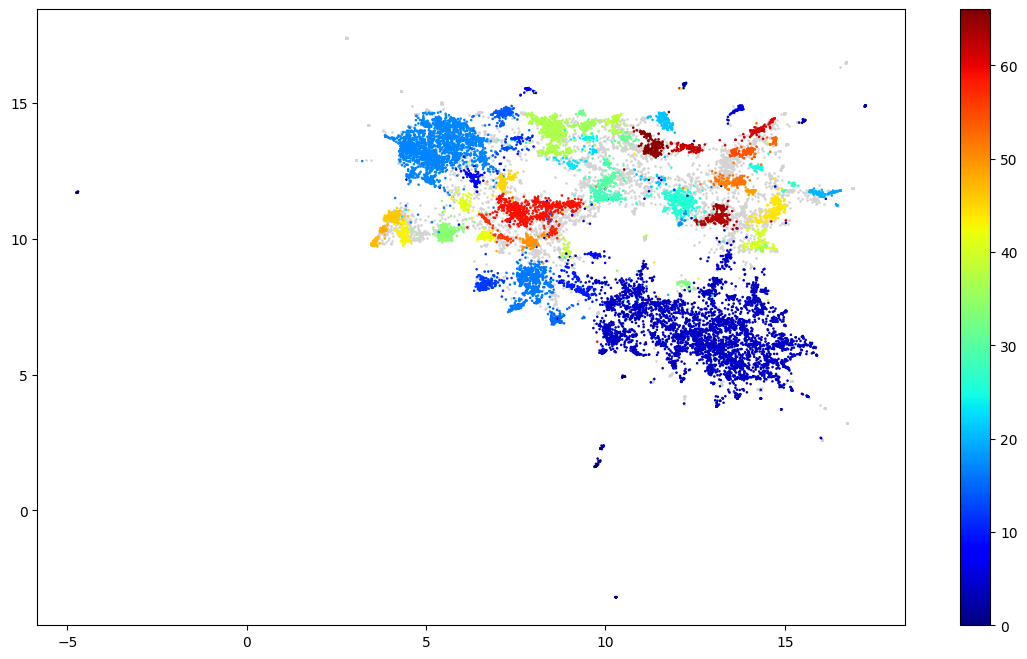

In [11]:
predef_pos_model_st1 = TopicModelling(np.array([np.array(embedding) for embedding in positive_reviews_predef.embeddings_st1],dtype=np.float32), 'st1')
positive_best_clusters = predef_pos_model_st1.generate_clusters(n_neighbors = 10, 
                                              n_components = 6, 
                                              min_cluster_size = 30, 
                                              min_samples = None,
                                              random_state=42)
labels_manual, cost_manual = predef_pos_model_st1.score_clusters(positive_best_clusters)
print(labels_manual)
print(cost_manual)
predef_pos_model_st1.best_clusters = positive_best_clusters
predef_pos_model_st1.plot_best_clusters()

In [12]:
from collections import Counter

def remov_duplicates(input):
 
    # split input string separated by space
    input = input.split(" ")
 
    # now create dictionary using counter method
    # which will have strings as key and their 
    # frequencies as value
    UniqW = Counter(input)
 
    # joins two adjacent elements in iterable way
    s = " ".join(UniqW.keys())
    return s

In [14]:
df_summary_pos_model_st1, labeled_docs_pos_model_st1 = predef_pos_model_st1.apply_and_summarize_labels(positive_reviews_predef[['year','review']])

In [15]:
labeled_docs_pos_model_st1=labeled_docs_pos_model_st1.rename(columns={'label_st1': 'label_num'})

In [16]:
df_summary_pos_model_st1 = df_summary_pos_model_st1.rename(columns={'label_st1': 'label_num'})
df_summary_pos_model_st1['label']=df_summary_pos_model_st1['label'].apply(remov_duplicates)
df_summary_pos_model_st1

,label_num,count,label
5,4,4490,recommend product price
0,-1,4022,bought tablet year
18,17,2046,tablet price
60,59,647,great book reader
17,16,616,screen camera quality
...,...,...,...
40,39,35,works wifi internet
23,22,33,bought tablet grandson gift
19,18,33,great kid toddler
8,7,33,tab price


In [18]:
df_summary_pos_model_st1.head(10)

,label_num,count,label
5,4,4490,recommend product price
0,-1,4022,bought tablet year
18,17,2046,tablet price
60,59,647,great book reader
17,16,616,screen camera quality
38,37,608,tablet kid
27,26,365,easy product kid child
35,34,238,love kindle price
13,12,232,love memory sd
45,44,230,gift family


In [15]:
df_summary_neg_model_st1, labeled_docs_neg_model_st1 = predef_neg_model_st1.apply_and_summarize_labels(negative_reviews_predef[['year','review']])

In [16]:
labeled_docs_neg_model_st1 = labeled_docs_neg_model_st1.rename(columns={'label_st1': 'label_num'})

In [17]:
df_summary_neg_model_st1 = df_summary_neg_model_st1.rename(columns={'label_st1': 'label_num'})
df_summary_neg_model_st1.head(10)

,label_num,count,label
0,-1,896,like_tablet_screen
14,13,303,like_app_store
1,0,141,like_ad_screen
5,4,110,purchased_kindle_fire
21,20,105,tablet_tablet_price
24,23,84,waste_issue_product_money
12,11,83,slow_slow_bit_time
9,8,77,charge_tablet_charger_port
13,12,69,connect_wifi_internet
3,2,68,camera_camera_quality


In [18]:
df_summary_neu_model_st1, labeled_docs_neu_model_st1 = predef_neutral_model_st1.apply_and_summarize_labels(neutral_reviews_predef[['year','review']])

In [19]:
labeled_docs_neu_model_st1 = labeled_docs_neu_model_st1.rename(columns={'label_st1': 'label_num'})

In [20]:
df_summary_neu_model_st1 = df_summary_neu_model_st1.rename(columns={'label_st1': 'label_num'})
df_summary_neu_model_st1.head(10)

,label_num,count,label
0,-1,2505,bought_tablet_app
12,11,510,bought_2_gift_kid
25,24,414,bought_fire_kindle
26,25,331,use_store_app
33,32,203,bought_book_tablet_reader
1,0,182,purchased_card_memory_sd
34,33,172,use_email_web
11,10,171,set_control_kid
7,6,170,bought_item_year_son
13,12,146,got_lot_sale_price


In [21]:
labeled_docs_pos_model_st1['sentiment'] = 'Positive'
labeled_docs_neu_model_st1['sentiment'] = 'Neutral'
labeled_docs_neg_model_st1['sentiment'] = 'Negative'

In [22]:
df_summary_pos_model_st1['sentiment'] = 'Positive'
df_summary_neu_model_st1['sentiment'] = 'Neutral'
df_summary_neg_model_st1['sentiment'] = 'Negative'

In [23]:
labels_predef = pd.concat([labeled_docs_pos_model_st1,labeled_docs_neu_model_st1,labeled_docs_neg_model_st1])
labels_predef

,year,review,label_num,label,sentiment
0,2016,"Good basic tablet for checking email , web bro...",17,tablet_tablet_price,Positive
1,2016,I love this tablet.,-1,bought_tablet_year,Positive
2,2016,It was a great buy.,4,recommend_product_price,Positive
3,2016,I would strongly recommend buying it.,4,recommend_product_price,Positive
4,2016,It's a great reader but also good for surfing ...,59,great_book_reader,Positive
...,...,...,...,...,...
2479,2017,I only wish we had things like this in the dar...,17,bought_tablet_kid,Negative
2480,2017,The omnipresent advertising is annoying but al...,0,like_ad_screen,Negative
2481,2017,"Only complaint is, you have to reconnect it to...",12,connect_wifi_internet,Negative
2482,2017,"my daughter cant put this thing down, so it's ...",-1,like_tablet_screen,Negative


In [73]:
summary_predef = pd.concat([df_summary_pos_model_st1,df_summary_neu_model_st1,df_summary_neg_model_st1])
summary_predef

,label_num,count,label,sentiment
5,4,4490,recommend product price,Positive
0,-1,4022,bought tablet year,Positive
18,17,2046,tablet tablet price,Positive
60,59,647,great book reader,Positive
17,16,616,screen camera quality,Positive
...,...,...,...,...
17,16,23,dropped cord floor foot,Negative
2,1,23,hear star speaker volume,Negative
7,6,19,freezes game time tablet,Negative
11,10,18,slow tablet time,Negative


In [74]:
with open(f'Reviews_{product_asin}_label_predef.pkl', 'wb') as f:
    pickle.dump(labels_predef, f)
labels_predef

,year,review,label_num,label,sentiment
0,2016,"Good basic tablet for checking email , web bro...",17,tablet tablet price,Positive
1,2016,I love this tablet.,-1,bought tablet year,Positive
2,2016,It was a great buy.,4,recommend product price,Positive
3,2016,I would strongly recommend buying it.,4,recommend product price,Positive
4,2016,It's a great reader but also good for surfing ...,59,great book reader,Positive
...,...,...,...,...,...
2479,2017,I only wish we had things like this in the dar...,17,bought tablet kid,Negative
2480,2017,The omnipresent advertising is annoying but al...,0,like ad screen,Negative
2481,2017,"Only complaint is, you have to reconnect it to...",12,connect wifi internet,Negative
2482,2017,"my daughter cant put this thing down, so it's ...",-1,like tablet screen,Negative


In [84]:
with open(f'Reviews_{product_asin}_summary_predef.pkl', 'wb') as f:
    pickle.dump(summary_predef, f)
summary_predef

,label_num,count,label,sentiment
9,8,2172,bought screen price,Positive
7,6,1708,tablet tablet price,Positive
1,0,528,love kindle fire,Positive
3,2,175,loves book tablet game,Positive
0,-1,158,easy book tablet beginner,Positive
8,7,56,life charge battery,Positive
4,3,47,recommend product friend people,Positive
2,1,44,works charm trick,Positive
5,4,44,love card sd,Positive
6,5,42,easy function setup super,Positive
